In [1]:
import hydra
from glob import  glob
from proteoscope.data import ProteolocDM
from proteoscope.modules import ProteolocLM
import numpy as np
from omegaconf import OmegaConf


BASE_DIR = "/home/ec2-user/outputs/proteoloc/2023-09-09/17-42-50" # Best proteoscope - ESM-full

# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-04/16-34-38" # 25 x 25 cond latent
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-04/22-36-50" # 25 x 25 cond nuclei + latent
# BASE_DIR = "/home/ec2-user/outputs-proteoscope/2023-08-05/01-50-26" # 25 x 25 cond nuclei + latent

config_dir = BASE_DIR + "/.hydra"

with hydra.initialize_config_dir(config_dir=config_dir):
    config = hydra.compose(config_name="config", overrides=OmegaConf.load(config_dir + "/overrides.yaml"))

    chkpts = glob(BASE_DIR + "/checkpoints/*.ckpt")
    chkpts.sort()
    chkpt = chkpts[-2]
    print('   Using ', chkpt)


    pdm = ProteolocDM(
        labels_path=config.data.labels_path,
        sequences_path=config.data.sequences_path,
        batch_size=config.trainer.batch_size,
        num_workers=config.trainer.num_workers,
        sequence_embedding=config.data.sequence_embedding,
    )
    pdm.setup()

    plm = ProteolocLM.load_from_checkpoint(
        chkpt,
        module_config=config.module,
    )

    plm.eval()
    plm.cuda()

/tmp/ipykernel_9440/2486297870.py:17: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with hydra.initialize_config_dir(config_dir=config_dir):


   Using  /home/ec2-user/outputs/proteoloc/2023-09-09/17-42-50/checkpoints/epoch=12-step=525.ckpt


## Generate samples

In [3]:
dl = pdm.test_dataloader()

In [4]:
from tqdm import  tqdm
import torch


true_labels = []
predicted_labels = []

for batch in tqdm(dl):
    batch['sequence_embed'] = batch['sequence_embed'].to('cuda')
    batch['sequence_mask'] = batch['sequence_mask'].to('cuda')    
    batch['truncation'] = batch['truncation'].to('cuda')    
    logits = plm(batch)
    prediction = torch.argmax(logits, -1)
    predicted_labels.append(prediction.detach().cpu().numpy())
    true_labels.append(batch['localization'].detach().cpu().numpy())
true_labels = np.concatenate(true_labels, axis=0)
predicted_labels = np.concatenate(predicted_labels, axis=0)

100%|██████████| 87/87 [00:15<00:00,  5.76it/s]


In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score


acc = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy {acc}')

cm = confusion_matrix(true_labels, predicted_labels)

Accuracy 0.8200504868373603


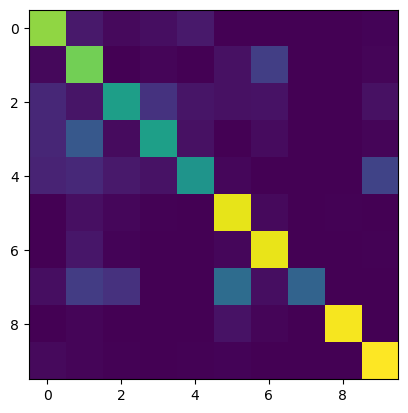

In [6]:
import matplotlib.pyplot as plt

plt.imshow(cm / cm.sum(axis=1)[:, None])

## Run on OpenCell protein embeddings

In [2]:
# import pandas as pd

# seq_path = '/home/ec2-user/cytoself-data/sequences.csv'
# seq = pd.read_csv(seq_path, index_col=0)
# # seq['Length'] = seq["Peptide"].apply(lambda x: len(x.replace("*", "")))
# # seq.to_csv(seq_path)

In [2]:
plds = ProteolocDM(
    labels_path='/home/ec2-user/cytoself-data/sequences.csv',
    sequences_path=None, #'/home/ec2-user/cytoself-data/ESM_sequence_embeddings_full.zarr',
    batch_size=1,
    num_workers=0,
    sequence_embedding=None, #'ESM-full',
)
plds.setup()

In [3]:
from tqdm import  tqdm
import torch


embeds = []
with torch.no_grad():
    for batch in tqdm(plds.predict_dataloader()):
        # batch['sequence_embed'] = batch['sequence_embed'].to('cuda')
        # batch['sequence_mask'] = batch['sequence_mask'].to('cuda')    
        batch['truncation'] = batch['truncation'].to('cuda')    
        seq_embeds = plm.embed(batch)
        embeds.append(seq_embeds.detach().cpu().numpy())
embeds = np.concatenate(embeds, axis=0)

100%|██████████| 1311/1311 [02:28<00:00,  8.81it/s]


ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 377 and the array at index 1 has size 340

In [4]:
X = embeds[0]

In [5]:
import zarr
import os


PROTEIN_EMBED_PATH = '/home/ec2-user/cytoself-data/ESM_sequence_embeddings_full_lora2.zarr'

z_embedding_prot = zarr.open(
    PROTEIN_EMBED_PATH,
    mode="w",
        shape=(len(embeds), 1024 + 1, X.shape[2]),
        chunks=(1, None, None),
    dtype="float32",
)

In [6]:
for i, zz in enumerate(embeds):
    ll = min(1024, len(zz[0]))
    z_embedding_prot[i, 1:1+ll, :] = zz[0][:ll]

: 

In [17]:
embeds[2].shape

(1, 459, 1280)

In [18]:
z_embedding_prot.shape

(1, 1025, 1280)

In [1]:
from peft import LoraConfig, TaskType
import esm

In [8]:
peft_config = LoraConfig(target_modules=["k_proj", "v_proj", "q_proj", "out_proj", "fc1", "fc2"], inference_mode=False, r=8, lora_alpha=32, lora_dropout=0.1)


In [3]:
model, alphabet = esm.pretrained.esm2_t33_650M_UR50D()

In [4]:
from peft import get_peft_model

In [9]:
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 6,082,560 || all params: 657,125,814 || trainable%: 0.9256309629619877


In [13]:
list(model.parameters())[0]

torch.Size([33, 1280])

In [19]:
print(model)

ESM2(
  (embed_tokens): Embedding(33, 1280, padding_idx=1)
  (layers): ModuleList(
    (0): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (q_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (out_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (rot_emb): RotaryEmbedding()
      )
      (self_attn_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
      (fc1): Linear(in_features=1280, out_features=5120, bias=True)
      (fc2): Linear(in_features=5120, out_features=1280, bias=True)
      (final_layer_norm): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
    )
    (1): TransformerLayer(
      (self_attn): MultiheadAttention(
        (k_proj): Linear(in_features=1280, out_features=1280, bias=True)
        (v_proj): Linear(in_features=1280, out_features=1280, bia

In [3]:
import pandas as pd

data_path = '/home/ec2-user/cytoself-data/labels.csv'
data_path2 = '/home/ec2-user/cytoself-data/sequences.csv'
df = pd.read_csv(data_path, index_col=0)
df2 = pd.read_csv(data_path2, index_col=0)

/tmp/ipykernel_106676/968085745.py:5: DtypeWarning: Columns (17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_path, index_col=0)


In [13]:
df2['loc'] = df2['localization'].astype('category').cat.codes

In [15]:
df2.to_csv(data_path2)